This notebook is an example of using the Particles class in particles.py to read, process, and plot data from .lis files.

In [1]:
import numpy as np
import glob
from tqdm import tqdm

import particles as part
import cartographic as cart

plotting_movies = False

if not plotting_movies:
     # WARNING: movie plots will not work in parallel if matplotlib is imported before plot_Ekin_distribution_movie
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

In [2]:
# path to folder containing the .lis files
datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin/test16_part-tracking/'

filenames = sorted(glob.glob(datapath + 'joined_lis/*.lis'))

particles = part.Particles(relativistic=False)
for filename in tqdm(filenames):
    particles.add_snapshot(filename, verbose=False)
    
particles.sort()

100%|██████████| 41/41 [00:00<00:00, 2839.65it/s]


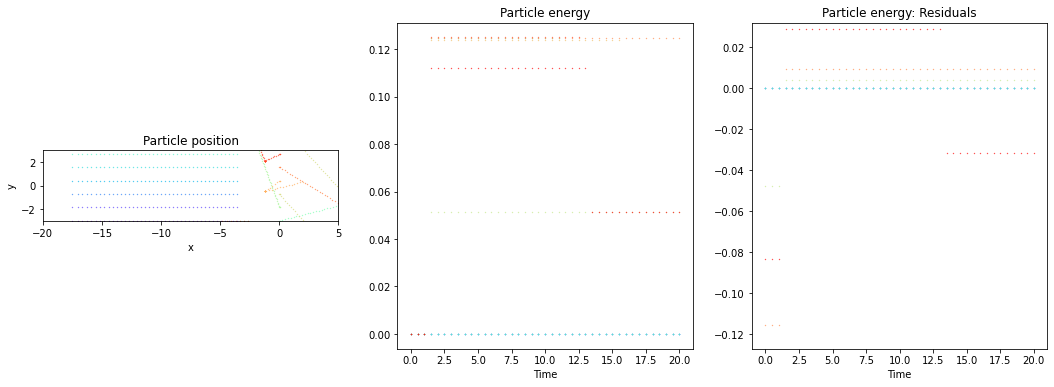

In [3]:
if not plotting_movies:
    
    fig = plt.figure(figsize=(18,6))
    gs = gridspec.GridSpec(1,3)

    plt.subplot(gs[0,0])
    particles.plot_pos2D(plt.gca(), color_by='particle')

    particles.update_aux_data()

    plt.subplot(gs[0,1])
    particles.plot_Ekin_vs_time(plt.gca())

    plt.subplot(gs[0,2])
    particles.plot_Ekin_vs_time(plt.gca(), residuals=True)

    plt.show()
    plt.close()

  0%|          | 0/1 [00:00<?, ?it/s]/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
100%|██████████| 1/1 [00:00<00:00, 342.36it/s]


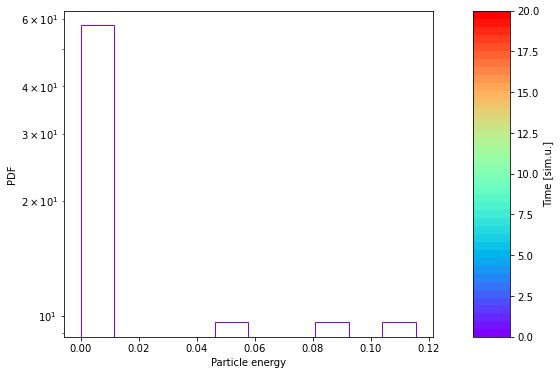

In [4]:
if not plotting_movies:
    fig = plt.figure(figsize=[8,6])
    gs = gridspec.GridSpec(1,2, width_ratios=[1,0.1])

    plt.subplot(gs[0,0])
    particles.plot_Ekin_distribution(plt.gca(), history=True, navg=100, cax=plt.subplot(gs[0,1]))

    plt.show()
    plt.close()

/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:493: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:494: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:494: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:496: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/cartographic.py:80: RuntimeWarning: invalid value encountered in true_divide
  colors = (bin_vals 

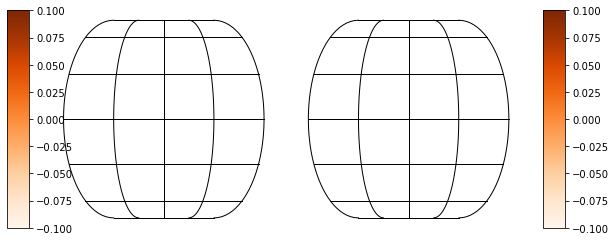

In [5]:
# single frame
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1,4, width_ratios=(0.1,1,1,0.1))

plt.subplot(gs[0,1])
particles.plot_direction_distribution_3D(plt.gca(), cart.projection_EckertIV, 8, i=0, cax=plt.subplot(gs[0,0]), cmap='Oranges')

plt.subplot(gs[0,2])
particles.plot_direction_distribution_3D(plt.gca(), cart.projection_EckertIV, 8, i=0, cax=plt.subplot(gs[0,3]), weights='mom', recalculate=False, cmap='Oranges')

plt.show()
plt.close()

/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:493: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:494: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:494: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:495: RuntimeWarning: invalid value encountered in greater
  self.vel_phi = np.where(vel[:,:,1] > 0, self.vel_phi, 2.*np.pi - self.vel_phi)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:496: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi

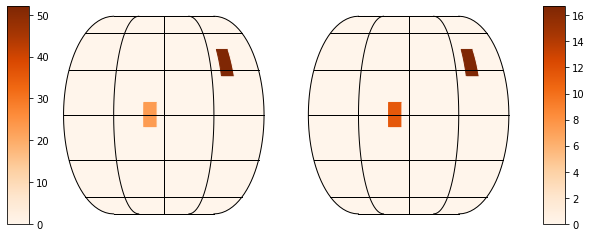

In [6]:
# single statistics for all time steps
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1,4, width_ratios=(0.1,1,1,0.1))

plt.subplot(gs[0,1])
particles.plot_direction_distribution_3D(plt.gca(), cart.projection_EckertIV, 8, cax=plt.subplot(gs[0,0]), cmap='Oranges')

plt.subplot(gs[0,2])
particles.plot_direction_distribution_3D(plt.gca(), cart.projection_EckertIV, 8, cax=plt.subplot(gs[0,3]), weights='mom', recalculate=True, cmap='Oranges')

plt.show()
plt.close()

In [6]:
# WARNING: movie plots will not work in parallel if matplotlib is imported before calling this function!
#  - if plt is loaded, you will (sadly... :/) need to restart the kernel or use a separate session to call this function
if plotting_movies:
    particles.plot_Ekin_distribution_movie(nproc=8, navg=100, force=True, xmin=0.005, xmax=0.02)

------------------------------------------------------
**For plotting dashboard movies, only run the cells below**

In [1]:
import glob
import os
import numpy as np

datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin/test16_part-tracking/'
outpath = './temp_dashboard/'
if not os.path.exists(outpath):
    os.makedirs(outpath)
    
out_dt_vtk = 0.5
out_dt_lis = 0.5
plot_all_traces = True

vtk_filenames = sorted(glob.glob(datapath + 'joined_vtk/*.vtk'))
lis_filenames = sorted(glob.glob(datapath + 'joined_lis/*.lis'))

particle_trace_length = 10
particle_diags_navg = 10

# find the particles with highest and median energy at the end
import particles as part
particles = part.Particles(relativistic=True)
particles.add_snapshot(lis_filenames[-1], verbose=False)
particles.sort()
if not plot_all_traces:
    selection_median = particles.find_median_Ekin(n=4)
    selection_highest = particles.find_highest_Ekin(n=4)
del particles

# WARNING: add_snapshot_FIFO below is NOT embarassingly parallelizable, but does significantly save memory
def dashboard_frame (i_vtk, verbose=False, particles=None, save=True, recalculate=False):

    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    from read_vtk import vtk
    import particles as part
    import cartographic as cart

    vtk_time = i_vtk * out_dt_vtk # presumably we can trust this..
    
    print('Processing vtk no %i, vtk_time = %.2e..' % (i_vtk, vtk_time), flush=True)
    
    # see whether we can skip the file as already plotted
    fileno = int(vtk_filenames[i_vtk].split('/')[-1].split('.')[-2])
    outfile = (outpath + 'dashboard_%05i.png') % fileno
    if save and particles == None and not recalculate and os.path.exists(outfile):
        print(' - file already plotted, skipping.', flush=True)
        return particles
    
    # number of lis-frames for particle traces and averaging
    particle_load_frames = max(particle_trace_length, particle_diags_navg)

    if verbose:
        print(' - aligning a lis file..', flush=True)

    # figure out the lis(particle)-snapshot index
    i_lis = min(len(lis_filenames)-1, int(i_vtk * out_dt_vtk/out_dt_lis)) # initial guess
    particles = part.Particles(relativistic=True)
    lis_time, lis_dt = particles.get_time(lis_filenames[i_lis])
    safety = 0 # just in case, to break an infinit loop
    while abs(lis_time-vtk_time) / lis_dt > 1.2:
        diff_i_lis = int((vtk_time-lis_time) / lis_dt)
        i_lis += diff_i_lis
        lis_time, lis_dt = particles.get_time(lis_filenames[i_lis])
        safety += 1
        if safety > 30:
            print('Could not find matching lis snapshot for vtk no %i. The closest match is lis no %i [t_vtk=%.2e, t_lis=%.2e].' % (i_vtk, i_lis, vtk_time, lis_time))
            break
    if verbose:
        print('     lis file no %i, lis_time = %.2e' % (i_lis, lis_time), flush=True)

    # initialize the plot
    fig = plt.figure(figsize=(24,12))
    gs = gridspec.GridSpec(4,7, width_ratios=[0.02,0.5,0.5,0.02,0.48,0.48,0.02], hspace=0.3)
    plt.suptitle('Time = %.2f sim.u.' % vtk_time)

    # ----------------------------------------------------------

    if verbose:
        print(' - processing vtk data..', flush=True)

    # load, process, and plot the vtk file (mhd quantities)

    data_vtk = vtk(vtk_filenames[i_vtk], out_dt=out_dt_vtk)

    # calculate auxiliary data

    # SR quantities
    # NOTE: in Athena 4.2 vel1, vel2, vel3 are 3-velocities. Instead Athena++ uses 4-velocities in the code (so they would need to be translated).
    vel_tot_sqr = data_vtk['vel1']**2 + data_vtk['vel2']**2 + data_vtk['vel3']**2
    data_vtk['vel_tot'] = np.sqrt(vel_tot_sqr)
    data_vtk['gamma'] = 1./np.sqrt(1.-vel_tot_sqr)
    del vel_tot_sqr

    # total Bcc in observer frame
    data_vtk['Bcc_tot'] = np.sqrt(data_vtk['Bcc1']**2 + data_vtk['Bcc2']**2 + data_vtk['Bcc3']**2)

    # Bcc in the fluid frame
    data_vtk['Bcc_fluid_0'] = data_vtk['gamma'] * (data_vtk['vel1']*data_vtk['Bcc1'] + data_vtk['vel2']*data_vtk['Bcc2'] + data_vtk['vel3']*data_vtk['Bcc3'])
    data_vtk['Bcc_fluid_1'] = data_vtk['Bcc1'] / data_vtk['gamma'] + data_vtk['Bcc_fluid_0'] * data_vtk['vel1']
    data_vtk['Bcc_fluid_2'] = data_vtk['Bcc2'] / data_vtk['gamma'] + data_vtk['Bcc_fluid_0'] * data_vtk['vel2']
    data_vtk['Bcc_fluid_3'] = data_vtk['Bcc3'] / data_vtk['gamma'] + data_vtk['Bcc_fluid_0'] * data_vtk['vel3']
    Bcc_fluid_tot_sqr = data_vtk['Bcc_fluid_1']**2 + data_vtk['Bcc_fluid_2']**2 + data_vtk['Bcc_fluid_3']**2
    data_vtk['Bcc_fluid_tot'] = np.sqrt(Bcc_fluid_tot_sqr)

    # plasma parameters
    data_vtk['plasma_beta'] = 2.*data_vtk['press'] / Bcc_fluid_tot_sqr
    data_vtk['magnetization'] = Bcc_fluid_tot_sqr / data_vtk['rho']
    del Bcc_fluid_tot_sqr

    # plot

    plt.subplot(gs[0,1:3])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['rho'])
    plt.title('Density (fl. frame) [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[0,0]))

    plt.subplot(gs[0,3:6])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['press'])
    plt.title('Pressure (fl. frame) [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[0,6]))

    plt.subplot(gs[1,1:3])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['Bcc_tot'])
    plt.title('Bfield (obs frame) [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[1,0]))

    plt.subplot(gs[1,3:6])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['plasma_beta'])
    plt.title('Plasma $\\beta$')
    plt.ylabel('y [sim.u.]')
    plt.xlabel('x [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[1,6]))

    plt.subplot(gs[2,1:3])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['magnetization'])
    plt.title('Magnetization')
    plt.ylabel('y [sim.u.]')
    plt.xlabel('x [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[2,0]))
    
    # set the plot range to vtk data
    for ax in [plt.subplot(gs[0,1:3]), plt.subplot(gs[0,3:6]), plt.subplot(gs[1,1:3]), plt.subplot(gs[1,3:6]), plt.subplot(gs[2,1:3])]:
        ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
        ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))

    # clean up
    del data_vtk

    if verbose:
        print('     done.', flush=True)

    # ----------------------------------------------------------

    if verbose:
        print(' - processing lis data..', flush=True)

    # load, process, and plot the lis file (particles)
    if particles == None:
        particles = part.Particles(relativistic=True)

    if particles.initialized:
        particles.add_snapshot_FIFO(lis_filenames[i_lis], verbose=False)
    else:
        # load the first nframes snapshots
        for iload in range(max(i_lis-particle_load_frames+1,0), i_lis+1):
            particles.add_snapshot(lis_filenames[iload], verbose=False)
        particles.sort()
    particles_size = len(particles.times)

    # only plot if we have sufficient time for averaging
    if i_lis > particle_diags_navg-1:
        plt.subplot(gs[3,1:3])
        title = 'Particle $E_{\\rm kin}$ distribution'
        if particle_diags_navg > 1:
            title += (' (avg. over $\\Delta t \\sim %.2f$ sim.u.)' % (particle_diags_navg*out_dt_lis,))
        particles.plot_Ekin_distribution(plt.gca(), i=(particles_size-1), navg=particle_diags_navg)
        plt.xlabel(title)

    plt.subplot(gs[2,4])
    plt.title('Particle direction distribution')
    particles.plot_direction_distribution_3D(plt.gca(), cart.projection_EckertIV, 8, cax=plt.subplot(gs[2,3]), cmap='Oranges', i=(particles_size-1))

    plt.subplot(gs[2,5])
    plt.title('Particle momentum distribution')
    particles.plot_direction_distribution_3D(plt.gca(), cart.projection_EckertIV, 8, cax=plt.subplot(gs[2,6]), weights='mom', recalculate=False, cmap='Oranges', i=(particles_size-1))

    plt.subplot(gs[3,4], projection='polar')
    particles.plot_direction_distribution_2D(plt.gca(), 8, recalculate=False, i=(particles_size-1))

    plt.subplot(gs[3,5], projection='polar')
    particles.plot_direction_distribution_2D(plt.gca(), 8, weights='mom', recalculate=False, i=(particles_size-1))

    # plot particle traces
    for ax in [plt.subplot(gs[0,1:3]), plt.subplot(gs[0,3:6]), plt.subplot(gs[1,1:3]), plt.subplot(gs[1,3:6]), plt.subplot(gs[2,1:3])]:
        if plot_all_traces:
            particles.plot_pos2D(ax, color_by='r', annotations=False)
        else:
            particles.plot_pos2D(ax, color_by='r', annotations=False, selection=selection_median)
            particles.plot_pos2D(ax, color_by='b', annotations=False, selection=selection_highest)

    if verbose:
        print('     done.', flush=True)

    #plt.tight_layout()
    if save:
        plt.savefig(outfile, format='png', dpi=300, facecolor='w')
    else:
        plt.show()
    plt.close()
    
    print(' - frame done.', flush=True)
    
    return particles

In [2]:
# now, parallelize the frame generation
from pathos.pools import ProcessPool # an alternative to Python's multiprocessing
nproc = 1
chunks = np.array_split(range(len(vtk_filenames)), nproc)
def worker (ichunk):
    indices = chunks[ichunk]
    particles = None
    for i in indices:
        particles = dashboard_frame(i_vtk=i, particles=particles, verbose=True)
with ProcessPool(nproc) as pool:
    _ = pool.map(worker, list(range(nproc)))

Processing vtk no 0, vtk_time = 0.00e+00..
 - aligning a lis file..
     lis file no 0, lis_time = 0.00e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/cartographic.py:80: RuntimeWarning: invalid value encountered in true_divide
  colors = (bin_vals 

     done.
 - frame done.
Processing vtk no 1, vtk_time = 5.00e-01..
 - aligning a lis file..
     lis file no 1, lis_time = 5.02e-01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/cartographic.py:80: RuntimeWarning: invalid value encountered in true_divide
  colors = (bin_vals 

     done.
 - frame done.
Processing vtk no 2, vtk_time = 1.00e+00..
 - aligning a lis file..
     lis file no 2, lis_time = 1.00e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 3, vtk_time = 1.50e+00..
 - aligning a lis file..
     lis file no 3, lis_time = 1.50e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 4, vtk_time = 2.00e+00..
 - aligning a lis file..
     lis file no 4, lis_time = 2.00e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 5, vtk_time = 2.50e+00..
 - aligning a lis file..
     lis file no 5, lis_time = 2.50e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 6, vtk_time = 3.00e+00..
 - aligning a lis file..
     lis file no 6, lis_time = 3.00e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 7, vtk_time = 3.50e+00..
 - aligning a lis file..
     lis file no 7, lis_time = 3.50e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 8, vtk_time = 4.00e+00..
 - aligning a lis file..
     lis file no 8, lis_time = 4.00e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 9, vtk_time = 4.50e+00..
 - aligning a lis file..
     lis file no 9, lis_time = 4.50e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 10, vtk_time = 5.00e+00..
 - aligning a lis file..
     lis file no 10, lis_time = 5.00e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 11, vtk_time = 5.50e+00..
 - aligning a lis file..
     lis file no 11, lis_time = 5.50e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 12, vtk_time = 6.00e+00..
 - aligning a lis file..
     lis file no 12, lis_time = 6.00e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 13, vtk_time = 6.50e+00..
 - aligning a lis file..
     lis file no 13, lis_time = 6.50e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 14, vtk_time = 7.00e+00..
 - aligning a lis file..
     lis file no 14, lis_time = 7.00e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 15, vtk_time = 7.50e+00..
 - aligning a lis file..
     lis file no 15, lis_time = 7.50e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:497: RuntimeWarning: invalid value encountered in true_divide
  self.vel_theta = np.arctan(vel_xy/vel[:,:,2])
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in true_divide
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) # move to the [-pi,pi] range
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

     done.
 - frame done.
Processing vtk no 16, vtk_time = 8.00e+00..
 - aligning a lis file..
     lis file no 16, lis_time = 8.00e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 17, vtk_time = 8.50e+00..
 - aligning a lis file..
     lis file no 17, lis_time = 8.50e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 18, vtk_time = 9.00e+00..
 - aligning a lis file..
     lis file no 18, lis_time = 9.00e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 19, vtk_time = 9.50e+00..
 - aligning a lis file..
     lis file no 19, lis_time = 9.50e+00
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 20, vtk_time = 1.00e+01..
 - aligning a lis file..
     lis file no 20, lis_time = 1.00e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 21, vtk_time = 1.05e+01..
 - aligning a lis file..
     lis file no 21, lis_time = 1.05e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 22, vtk_time = 1.10e+01..
 - aligning a lis file..
     lis file no 22, lis_time = 1.10e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 23, vtk_time = 1.15e+01..
 - aligning a lis file..
     lis file no 23, lis_time = 1.15e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 24, vtk_time = 1.20e+01..
 - aligning a lis file..
     lis file no 24, lis_time = 1.20e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 25, vtk_time = 1.25e+01..
 - aligning a lis file..
     lis file no 25, lis_time = 1.25e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 26, vtk_time = 1.30e+01..
 - aligning a lis file..
     lis file no 26, lis_time = 1.30e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 27, vtk_time = 1.35e+01..
 - aligning a lis file..
     lis file no 27, lis_time = 1.35e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 28, vtk_time = 1.40e+01..
 - aligning a lis file..
     lis file no 28, lis_time = 1.40e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:499: RuntimeWarning: invalid value encountered in greater
  self.vel_phi = np.where(vel[:,:,1] > 0, self.vel_phi, 2.*np.pi - self.vel_phi)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) 

     done.
 - frame done.
Processing vtk no 29, vtk_time = 1.45e+01..
 - aligning a lis file..
     lis file no 29, lis_time = 1.45e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:499: RuntimeWarning: invalid value encountered in greater
  self.vel_phi = np.where(vel[:,:,1] > 0, self.vel_phi, 2.*np.pi - self.vel_phi)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) 

     done.
 - frame done.
Processing vtk no 30, vtk_time = 1.50e+01..
 - aligning a lis file..
     lis file no 30, lis_time = 1.50e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:499: RuntimeWarning: invalid value encountered in greater
  self.vel_phi = np.where(vel[:,:,1] > 0, self.vel_phi, 2.*np.pi - self.vel_phi)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) 

     done.
 - frame done.
Processing vtk no 31, vtk_time = 1.55e+01..
 - aligning a lis file..
     lis file no 31, lis_time = 1.55e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:499: RuntimeWarning: invalid value encountered in greater
  self.vel_phi = np.where(vel[:,:,1] > 0, self.vel_phi, 2.*np.pi - self.vel_phi)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) 

     done.
 - frame done.
Processing vtk no 32, vtk_time = 1.60e+01..
 - aligning a lis file..
     lis file no 32, lis_time = 1.60e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:499: RuntimeWarning: invalid value encountered in greater
  self.vel_phi = np.where(vel[:,:,1] > 0, self.vel_phi, 2.*np.pi - self.vel_phi)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) 

     done.
 - frame done.
Processing vtk no 33, vtk_time = 1.65e+01..
 - aligning a lis file..
     lis file no 33, lis_time = 1.65e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:499: RuntimeWarning: invalid value encountered in greater
  self.vel_phi = np.where(vel[:,:,1] > 0, self.vel_phi, 2.*np.pi - self.vel_phi)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) 

     done.
 - frame done.
Processing vtk no 34, vtk_time = 1.70e+01..
 - aligning a lis file..
     lis file no 34, lis_time = 1.70e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:499: RuntimeWarning: invalid value encountered in greater
  self.vel_phi = np.where(vel[:,:,1] > 0, self.vel_phi, 2.*np.pi - self.vel_phi)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) 

     done.
 - frame done.
Processing vtk no 35, vtk_time = 1.75e+01..
 - aligning a lis file..
     lis file no 35, lis_time = 1.75e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:499: RuntimeWarning: invalid value encountered in greater
  self.vel_phi = np.where(vel[:,:,1] > 0, self.vel_phi, 2.*np.pi - self.vel_phi)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) 

     done.
 - frame done.
Processing vtk no 36, vtk_time = 1.80e+01..
 - aligning a lis file..
     lis file no 36, lis_time = 1.80e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:499: RuntimeWarning: invalid value encountered in greater
  self.vel_phi = np.where(vel[:,:,1] > 0, self.vel_phi, 2.*np.pi - self.vel_phi)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:500: RuntimeWarning: invalid value encountered in less
  self.vel_phi = np.where(self.vel_phi < np.pi, self.vel_phi, self.vel_phi-2.*np.pi) 

     done.
 - frame done.
Processing vtk no 37, vtk_time = 1.85e+01..
 - aligning a lis file..
     lis file no 37, lis_time = 1.85e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 38, vtk_time = 1.90e+01..
 - aligning a lis file..
     lis file no 38, lis_time = 1.90e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 39, vtk_time = 1.95e+01..
 - aligning a lis file..
     lis file no 39, lis_time = 1.95e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.
Processing vtk no 40, vtk_time = 2.00e+01..
 - aligning a lis file..
     lis file no 40, lis_time = 2.00e+01
 - processing vtk data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - processing lis data..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


     done.
 - frame done.


In [3]:
# render the movie
try:
    print("Rendering the movie..", flush=True)
    command = ("ffmpeg -y -r 20 -f image2 -i \"%sdashboard_%%*.png\" -f mp4 -q:v 0 -vcodec mpeg4 -r 20 dashboard.mp4" % (outpath,))
    print(command, flush=True)
    os.system(command)
except Exception as e:
    print('Error while rendering movie:\n%s\n -- please try to manually convert the .png files generated in %s.' % (e, tempdir), flush=True)

Rendering the movie..
ffmpeg -y -r 20 -f image2 -i "./temp_dashboard/dashboard_%*.png" -f mp4 -q:v 0 -vcodec mpeg4 -r 20 dashboard.mp4


Processing vtk no 30, vtk_time = 1.50e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/vis/particle/particles.py:498: RuntimeWarning: invalid value encountered in arccos
  self.vel_phi = np.arccos(vel[:,:,0]/vel_xy)
/DATA/Dropbox/LOOTRPV/astro_pr

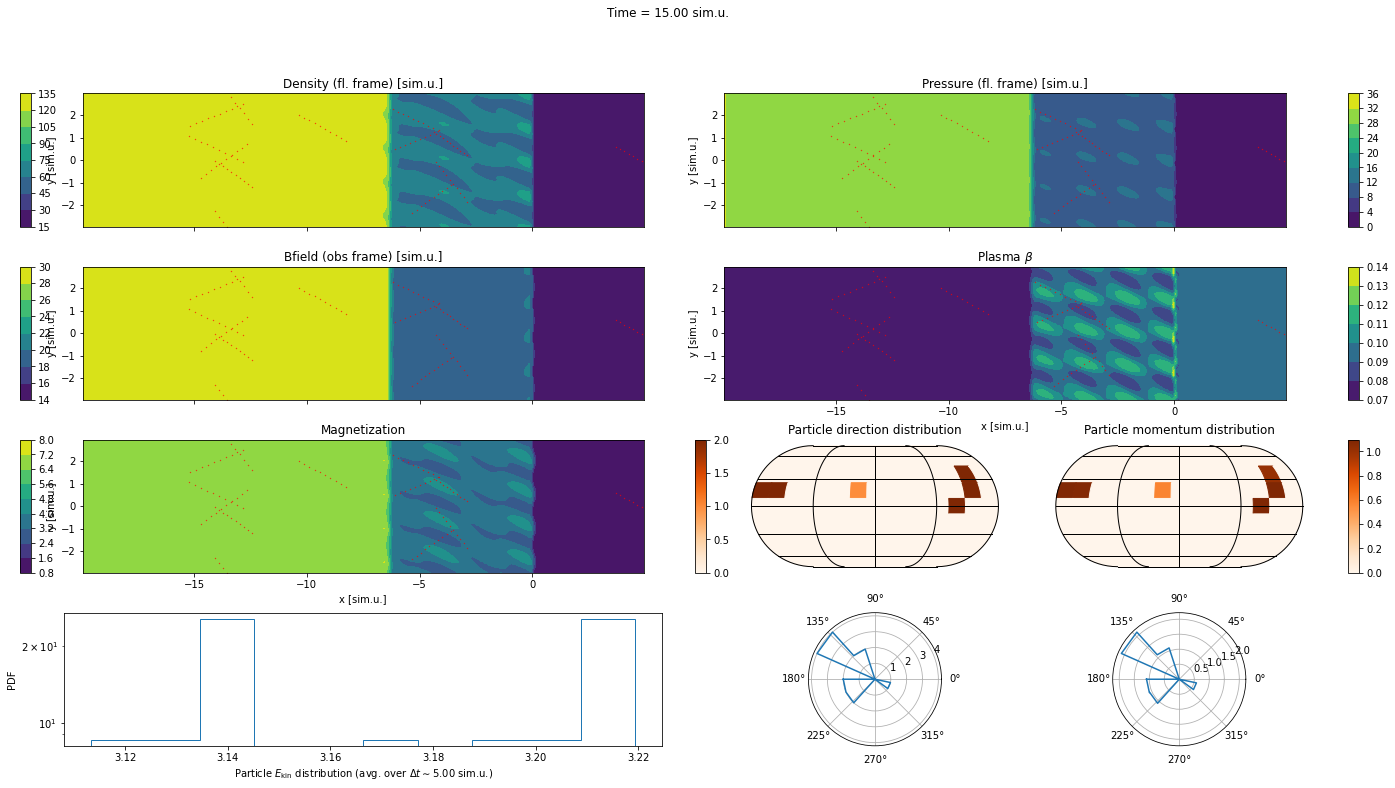

 - frame done.


In [4]:
particles = dashboard_frame(30, save=False)